In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from collections import deque
from sklearn import preprocessing

C:\Users\jeryf\Anaconda3\envs\tensorflow_env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
df = pd.read_csv('100_clean.csv', index_col=0)

df.drop(['Ticker', 'Date', 'Adjusted Close', 'Volume'], axis = 1, inplace=True)

In [72]:
X_train_total = []
Y_train_total = []

X_test_total = []
Y_test_total = []

seq_len = 12
keys = df['gvkey'].unique()
for key in keys:
    df_temp = df[df['gvkey']==key].drop('gvkey', axis=1) 
    df_temp['return'] = (df_temp['EBIT/EV']-df_temp['EBIT/EV'].shift(1))/df_temp['EBIT/EV'].shift(1)
    df_temp.drop('EBIT/EV', axis=1) 
    min_max_scaler = preprocessing.MinMaxScaler()
    col_names = df_temp.columns.values
    df_temp.loc[:, col_names[:-1]] = min_max_scaler.fit_transform(df_temp.loc[:, col_names[:-1]])
    df_temp.ffill(inplace=True)
    
    X_list = []
    Y_list = []
    for i in range(len(df_temp)-seq_len-4):
        X_list += [df_temp.iloc[i:i+seq_len].values]
        Y_list += [df_temp.iloc[i+seq_len+4, -1]]

    X = np.array(X_list)
    Y = np.array(Y_list)

    # First 72 quarters are for training
    if X.shape[0] >= 5: # Some gvkeys have no insufficient data (dont have 12 quarters of data).
                              # >=5 to ensure there is testing data.
        X_train = X[:int(len(X)*0.7)]
        X_test = X[int(len(X)*0.7):]

        Y_train = Y[:int(len(X)*0.7)]
        Y_test = Y[int(len(X)*0.7):]

        X_train_total += [X_train]
        X_test_total += [X_test]

        Y_train_total += [Y_train]
        Y_test_total += [Y_test]

In [74]:
X_train_total = np.vstack(X_train_total)
X_test_total = np.vstack(X_test)

Y_train_total = np.vstack(Y_train)
Y_test_total = np.vstack(Y_test)

Epoch 0 completed out of 100 loss: 0.38865846395492554
Epoch 1 completed out of 100 loss: 0.7550176903605461
Epoch 2 completed out of 100 loss: 0.20304140355437994
Epoch 3 completed out of 100 loss: 0.23365936800837517
Epoch 4 completed out of 100 loss: 0.1277894964441657
Epoch 5 completed out of 100 loss: 0.12126695550978184
Epoch 6 completed out of 100 loss: 0.03738219093065709
Epoch 7 completed out of 100 loss: 0.07687307195737958
Epoch 8 completed out of 100 loss: 0.03169666766189039
Epoch 9 completed out of 100 loss: 0.04762360919266939
Epoch 10 completed out of 100 loss: 0.029612740268930793
Epoch 11 completed out of 100 loss: 0.03502281615510583
Epoch 12 completed out of 100 loss: 0.02571940328925848
Epoch 13 completed out of 100 loss: 0.02901400299742818
Epoch 14 completed out of 100 loss: 0.024664444150403142
Epoch 15 completed out of 100 loss: 0.025706420186907053
Epoch 16 completed out of 100 loss: 0.0243302749004215
Epoch 17 completed out of 100 loss: 0.024493346689268947
E

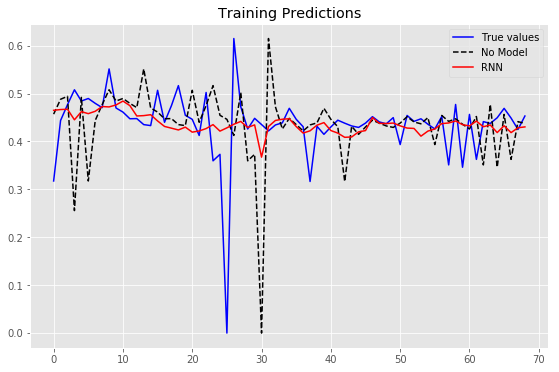

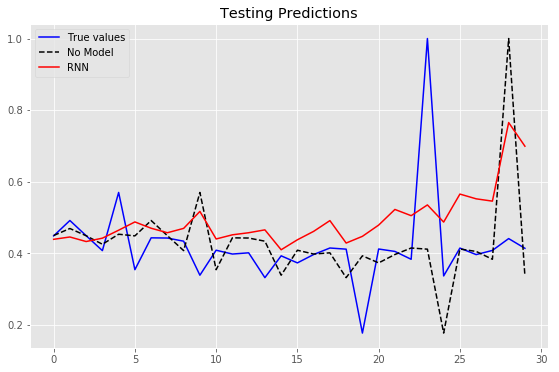

In [143]:
tf.reset_default_graph()

hm_epochs = 100
n_classes = 1
n_batches = 4
batch_size = X_train.shape[0]/n_batches
chunk_size = X_train.shape[2]
rnn_size = 64

x = tf.placeholder('float', [None, seq_len, chunk_size])
y = tf.placeholder('float')

def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size,n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}

#     layer = {'weights':tf.Variable(np.random.normal(size=(rnn_size,n_classes)).astype('float32')),
#              'biases':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, seq_len, 0)

    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size, state_is_tuple=True)
    lstm_dropout = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=1, output_keep_prob=1)
    outputs, states = rnn.static_rnn(lstm_dropout, x, dtype=tf.float32)

    output = tf.matmul(outputs[-1],layer['weights']) + layer['biases'] # softmax layer

#     attention_weights = tf.Variable(np.append(np.random.normal(size=seq_len-1), 5))
#     attention_weights = tf.Variable(tf.random_normal([seq_len]))
#     attention_ouput = tf.reduce_sum(tf.multiply(tf.convert_to_tensor(outputs) , tf.Variable(tf.random_normal([seq_len]))[:, tf.newaxis, tf.newaxis]), axis=0)
#     output = tf.matmul(attention_ouput,layer['weights']) + layer['biases'] # softmax layer

    return output

def train_neural_network(x):
    prediction = recurrent_neural_network(x)  
    cost = tf.losses.mean_squared_error(predictions=prediction, labels=y)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for i in range(n_batches):
                epoch_x = X_train[i*int(batch_size):(i+1)*int(batch_size)]
                epoch_y = Y_train[i*int(batch_size):(i+1)*int(batch_size)]

                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:', np.mean(epoch_loss))
    
        pred_train = sess.run(prediction, feed_dict={x: X_train.astype('float32')})[:,0]
        pred_test = sess.run(prediction, feed_dict={x: X_test.astype('float32')})[:,0]
        
        print('Testing MAE:', np.mean(np.abs(pred_test-Y_test)))
        print('Testing MSE:', np.mean((pred_test-Y_test)**2))
        
        plt.style.use('ggplot')

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
        ax.plot(Y_train, label='True values', color='blue')
        ax.plot(X_train[:, -1, -1], label='No Model', linestyle='--', color='black')
        ax.plot(pred_train, label='RNN', color='red')
        ax.legend()
        plt.title('Training Predictions')
        plt.show()
        
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
        ax.plot(Y_test, label='True values', color='blue')
        ax.plot(X_test[:, -1, -1], label='No Model', linestyle='--', color='black')
        ax.plot(pred_test, label='RNN', color='red')
        ax.legend()
        plt.title('Testing Predictions')
        plt.show()

train_neural_network(x)